In [2]:
#!/usr/bin/env python3
#pip install  rioxarray==0.3.1
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray
import numpy as np
import geopandas as gpd
import cartopy.crs as ccrs
import rasterio
import os
import matplotlib.colors
scriptsdir = os.getcwd()
from scipy.interpolate import griddata
from functools import reduce
import xarray
import itertools
import matplotlib.colors as mcolors
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.gridspec as gridspec
import cartopy.feature as cfeature
import warnings

In [9]:
import xarray as xr

models = ["GAM","GBM"]
taxas = ["Amphibians", "Mammals","Bird"]
habitats = ["pasture","forest","natural_land","cropland"]
scenarios = [ "rcp26","rcp60"]
historical_time = 1146
future_times = [65]

for scenario in scenarios:
    for habitat in habitats:
        for future_time in future_times:
            for model in models:
                combined_hist_newvalue_datasets = []
                combined_hist_sum_datasets = []
                combined_future_newvalue_datasets = []
                combined_future_sum_datasets = []
                
                for taxa in taxas:
                    # Historical
                    newvalue_hist = f"/storage/scratch/users/ch21o450/data/SR/{taxa}_{model}_{historical_time}_{scenario}_summedprobs_newvalue_{habitat}.nc"
                    sumbin_hist = f"/storage/scratch/users/ch21o450/data/SR/{taxa}_{model}_{historical_time}_{scenario}_summedprobs_sum_{habitat}.nc"

                    mean_value_bin_hist = xr.open_dataset(newvalue_hist, decode_times=False).to_array()
                    mean_sum_bin_hist = xr.open_dataset(sumbin_hist, decode_times=False).to_array()
                    
                    combined_hist_newvalue_datasets.append(mean_value_bin_hist)
                    combined_hist_sum_datasets.append(mean_sum_bin_hist)

                    # Future
                    newvalue_fut = f"/storage/scratch/users/ch21o450/data/SR/{taxa}_{model}_{future_time}_{scenario}_summedprobs_newvalue_{habitat}.nc"
                    sumbin_fut = f"/storage/scratch/users/ch21o450/data/SR/{taxa}_{model}_{future_time}_{scenario}_summedprobs_sum_{habitat}.nc"

                    mean_value_bin_future = xr.open_dataset(newvalue_fut, decode_times=False).to_array()
                    mean_sum_bin_future = xr.open_dataset(sumbin_fut, decode_times=False).to_array()

                    combined_future_newvalue_datasets.append(mean_value_bin_future)
                    combined_future_sum_datasets.append(mean_sum_bin_future)

                # Concatenate over the taxa dimension
                combined_hist_newvalue = xr.concat(combined_hist_newvalue_datasets, dim='taxa')
                combined_hist_sum = xr.concat(combined_hist_sum_datasets, dim='taxa')
                combined_future_newvalue = xr.concat(combined_future_newvalue_datasets, dim='taxa')
                combined_future_sum = xr.concat(combined_future_sum_datasets, dim='taxa')

                combined_hist_newvalue = combined_hist_newvalue.sum(dim='taxa')
                combined_hist_sum = combined_hist_sum.sum(dim='taxa')
                combined_future_newvalue = combined_future_newvalue.sum(dim='taxa')
                combined_future_sum = combined_future_sum.sum(dim='taxa')

                # Saving concatenated results to new files
                combined_hist_newvalue.to_netcdf(f"/storage/scratch/users/ch21o450/data/SR/{model}_{historical_time}_{scenario}_summedprobs_newvalue_{habitat}.nc", mode="w")
                combined_hist_sum.to_netcdf(f"/storage/scratch/users/ch21o450/data/SR/{model}_{historical_time}_{scenario}_summedprobs_sum_{habitat}.nc", mode = "w")
                combined_future_newvalue.to_netcdf(f"/storage/scratch/users/ch21o450/data/SR/{model}_{future_time}_{scenario}_summedprobs_newvalue_{habitat}.nc", mode="w")
                combined_future_sum.to_netcdf(f"/storage/scratch/users/ch21o450/data/SR/{model}_{future_time}_{scenario}_summedprobs_sum_{habitat}.nc", mode="w")


In [2]:
import xarray as xr
from tabulate import tabulate
from termcolor import colored
models = ["GAM", "GBM"]
taxas = ["Amphibians", "Mammals", "Bird"]
habitats = ["pasture", "forest", "natural_land", "cropland"]
scenarios = ["rcp26", "rcp60"]
historical_time = 1146
future_times = [65]

table = []


for taxa in taxas:
    for scenario in scenarios:
        for habitat in habitats:
            for future_time in future_times:
                for model in models:
                        # Historical
                        newvalue_hist = f"/storage/scratch/users/ch21o450/data/SR/{taxa}_{model}_{historical_time}_{scenario}_summedprobs_newvalue_{habitat}.nc"
                        sumbin_hist = f"/storage/scratch/users/ch21o450/data/SR/{taxa}_{model}_{historical_time}_{scenario}_summedprobs_sum_{habitat}.nc"

                        mean_value_bin_hist = xr.open_dataset(newvalue_hist, decode_times=False).to_array().mean().values.item()
                        mean_sum_bin_hist = xr.open_dataset(sumbin_hist, decode_times=False).to_array().mean().values.item()

                        # Future
                        newvalue_fut = f"/storage/scratch/users/ch21o450/data/SR/{taxa}_{model}_{future_time}_{scenario}_summedprobs_newvalue_{habitat}.nc"
                        sumbin_fut = f"/storage/scratch/users/ch21o450/data/SR/{taxa}_{model}_{future_time}_{scenario}_summedprobs_sum_{habitat}.nc"

                        mean_value_bin_future = xr.open_dataset(newvalue_fut, decode_times=False).to_array().mean().values.item()
                        mean_sum_bin_future = xr.open_dataset(sumbin_fut, decode_times=False).to_array().mean().values.item()

                        # Add data to table
                        row = [
                            scenario, habitat, future_time, model, taxa,
                            mean_value_bin_hist, mean_sum_bin_hist,
                            mean_value_bin_future, mean_sum_bin_future
                        ]
                        table.append(row)

# Define column headers
headers = ["Taxa","Scenario", "Habitat", "Future Time", "Model",
           "Mean Historical Newvalue", "Mean Historical Sum",
           "Mean Future Newvalue", "Mean Future Sum"]

# Print the table
print(tabulate(table, headers=headers, tablefmt="pipe"))


| Taxa   | Scenario     |   Habitat | Future Time   | Model      |   Mean Historical Newvalue |   Mean Historical Sum |   Mean Future Newvalue |   Mean Future Sum |
|:-------|:-------------|----------:|:--------------|:-----------|---------------------------:|----------------------:|-----------------------:|------------------:|
| rcp26  | pasture      |        65 | GAM           | Amphibians |                    2.229   |               1.93479 |                2.19532 |           1.88362 |
| rcp26  | pasture      |        65 | GBM           | Amphibians |                    3.14591 |               2.70496 |                3.1577  |           2.68384 |
| rcp26  | forest       |        65 | GAM           | Amphibians |                    4.25634 |               3.20072 |                4.27524 |           3.23886 |
| rcp26  | forest       |        65 | GBM           | Amphibians |                    6.55274 |               4.75523 |                6.63243 |           4.86946 |
| rcp26  |

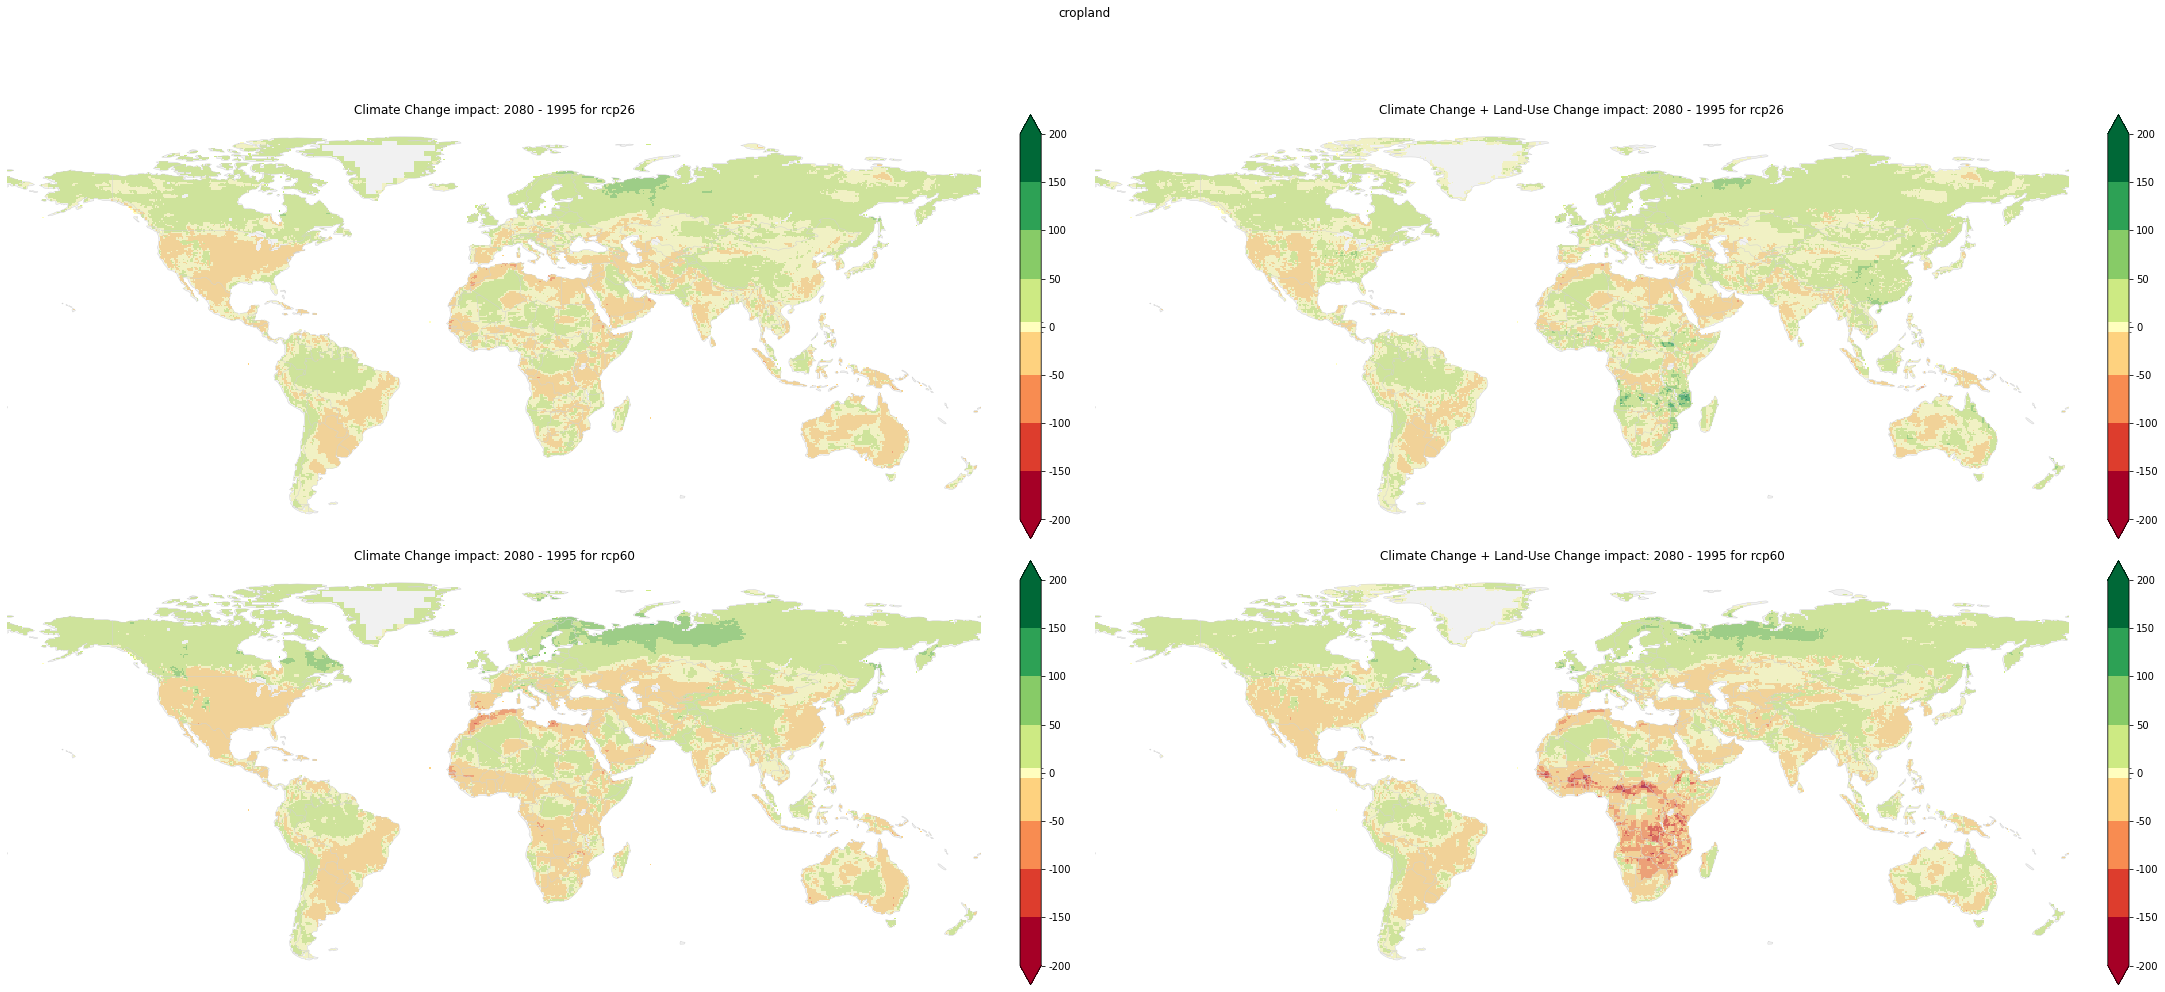

In [3]:
warnings.filterwarnings('ignore', category=UserWarning)

models =  ["GAM","GBM"]
habitats = ["cropland"]
scenarios = ["rcp26","rcp60"]

model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
years = ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050','2052', '2056', '2080', '2100', '2150', '2200', '2250']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(30, 15), subplot_kw={'projection': ccrs.PlateCarree()}, layout="compressed")
cmap = matplotlib.colors.ListedColormap(['white', 'green'])
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

plot_idx = 0

year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}
# Create empty arrays for storing the results for each taxa separately
diff_value_bin_combined_per_habitat = {}
diff_sum_bin_combined_per_habitat = {}
diff_combined_per_habitat = {}

for habitat in habitats:
    diff_value_bin_combined_per_habitat[habitat] = np.zeros([360, 720])
    diff_sum_bin_combined_per_habitat[habitat] = np.zeros([360, 720])
    diff_combined_per_habitat[habitat] = np.zeros([360, 720])
    for scenario in scenarios:
        historical_time = 1146
        future_times = [65]

        year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}

        for future_time in future_times:
            diff_value_bin_models = []
            diff_sum_bin_models = []
            diff_models = []
            percent_changes = []

            for model in models:
                newvalue_hist = f"/storage/scratch/users/ch21o450/data/SR/{model}_{historical_time}_{scenario}_summedprobs_newvalue_{habitat}.nc"
                sumbin_hist = f"/storage/scratch/users/ch21o450/data/SR/{model}_{historical_time}_{scenario}_summedprobs_sum_{habitat}.nc"

                mean_value_bin_hist = xr.open_dataset(newvalue_hist, decode_times=False).to_array()
                mean_sum_bin_hist = xr.open_dataset(sumbin_hist, decode_times=False).to_array()
                mean_value_bin_hist = mean_value_bin_hist.isel(variable=0)
                mean_sum_bin_hist = mean_sum_bin_hist.isel(variable=0)

                newvalue_fut = f"/storage/scratch/users/ch21o450/data/SR/{model}_{future_time}_{scenario}_summedprobs_newvalue_{habitat}.nc"
                sumbin_fut = f"/storage/scratch/users/ch21o450/data/SR/{model}_{future_time}_{scenario}_summedprobs_sum_{habitat}.nc"

                mean_value_bin_future = xr.open_dataset(newvalue_fut, decode_times=False).to_array()
                mean_value_bin_future = mean_value_bin_future.isel(variable=0)

                mean_sum_bin_future = xr.open_dataset(sumbin_fut, decode_times=False).to_array()
                mean_sum_bin_future = mean_sum_bin_future.isel(variable=0)

                # Calculate the differences (code you provided)
                diff_value_bin = mean_value_bin_future - mean_value_bin_hist
                diff_sum_bin = mean_sum_bin_future - mean_sum_bin_hist
                diff = diff_sum_bin - diff_value_bin
                change_percent = ((diff_sum_bin - diff_value_bin) / (diff_value_bin)) * 100  # added small value to avoid division by zero
                percent_changes.append(change_percent)

                # append the differences to the model-specific lists
                diff_value_bin_models.append(diff_value_bin)
                diff_sum_bin_models.append(diff_sum_bin)
                diff_models.append(diff)

            # Calculate the ensemble mean outside of the innermost loop
            diff_value_bin_ensemble = xr.concat(diff_value_bin_models, dim="ensemble").mean(dim="ensemble")
            diff_sum_bin_ensemble = xr.concat(diff_sum_bin_models, dim="ensemble").mean(dim="ensemble")

            diff_ensemble = diff_sum_bin_ensemble - diff_value_bin_ensemble

            # Append the ensemble mean to the overall results for this taxa
            diff_value_bin_combined_per_habitat[habitat] = diff_value_bin_ensemble
            diff_sum_bin_combined_per_habitat[habitat] = diff_sum_bin_ensemble
            diff_combined_per_habitat[habitat] = diff_ensemble

        # Calculate the overall species richness sum over all taxa
        diff_value_bin_combined = sum(diff_value_bin_combined_per_habitat.values())
        diff_sum_bin_combined = sum(diff_sum_bin_combined_per_habitat.values())
        diff_combined = sum(diff_combined_per_habitat.values())

        diff_newvalue = diff_value_bin_combined
        diff_sumbin = diff_sum_bin_combined
        diff = diff_combined

        land_sea_mask = xr.open_dataset("/storage/workspaces/wa_climate/climate_trt/chari/LUH2/remapped_luh2_ssp126.nc", decode_times=False).primf
        diff_newvalue_masked = diff_newvalue.where(land_sea_mask >= 0)
        diff_newvalue = diff_newvalue_masked.isel(time=0)

        # Create subplots for each future time and scenario
        if plot_idx >= len(axes.flatten()):
            break
        ax1 = axes.flatten()[plot_idx]
        ax2 = axes.flatten()[plot_idx + 1]

        labels = ['a', 'b']
        # Define the colormap and the range of values for the colorbar

        #vmin_b = diff_sum_bin.min().values
        #vmax_b = diff_sum_bin.max().values

        cmap = plt.colormaps['RdYlGn']
        boundaries = [-200, -150, -100, -50, -5, 5, 50, 100, 150, 200]  # Adjust these values according to your data
        norm = BoundaryNorm(boundaries, cmap.N)

        # Plot the ensemble mean difference for each panel
        im1 = ax1.pcolormesh(diff_newvalue['lon'].values, diff_newvalue['lat'].values, np.where(diff_newvalue.values != 0, diff_newvalue.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap,norm=norm)

        countries.plot(ax=ax1, color="lightgray", zorder=1, alpha=0.3)
        ax1.set_title(f"Climate Change impact: {year_indices[future_time]} - 1995 for {scenario}", loc='center')

        ax1.axis('off')
        ax1.coastlines(color='lightgray', linewidth=0.5)
        ax1.set_extent((-180, 180, -63, 90))
        ax1.add_feature(cfeature.BORDERS, color='lightgray', linewidth=0.5)

        ticks_b = np.array([-200, -150, -100, -50, 0, 50, 100, 150, 200])
        tick_labels = [str(int(tick)) for tick in ticks_b]

        cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.024, pad=0.04, spacing='proportional', ticks=ticks_b, extend='both')
        cbar1.set_ticklabels(tick_labels)

        im2 = ax2.pcolormesh(diff_sumbin['lon'].values, diff_sumbin['lat'].values, np.where(diff_sumbin.values != 0, diff_sumbin.values, np.nan), transform=ccrs.PlateCarree(), cmap=cmap,norm=norm)

        countries.plot(ax=ax2, color="lightgray", zorder=1, alpha=0.3)
        ax2.set_title(f"Climate Change + Land-Use Change impact: {year_indices[future_time]} - 1995 for {scenario}", loc='center')

        ax2.axis('off')
        ax2.coastlines(color='lightgray', linewidth=0.5)
        ax2.set_extent((-180, 180, -63, 90))
        ax2.add_feature(cfeature.BORDERS, color='lightgray', linewidth=0.5)
        cbar2 = plt.colorbar(im2, ax=ax2, fraction=0.024, pad=0.04, spacing='proportional', ticks=ticks_b, extend='both')
        cbar2.set_ticklabels(tick_labels)

        # Increase the plot index by 2 to move to the next triplet of subplots
        plot_idx += 2
fig.suptitle(habitat)

plt.show()


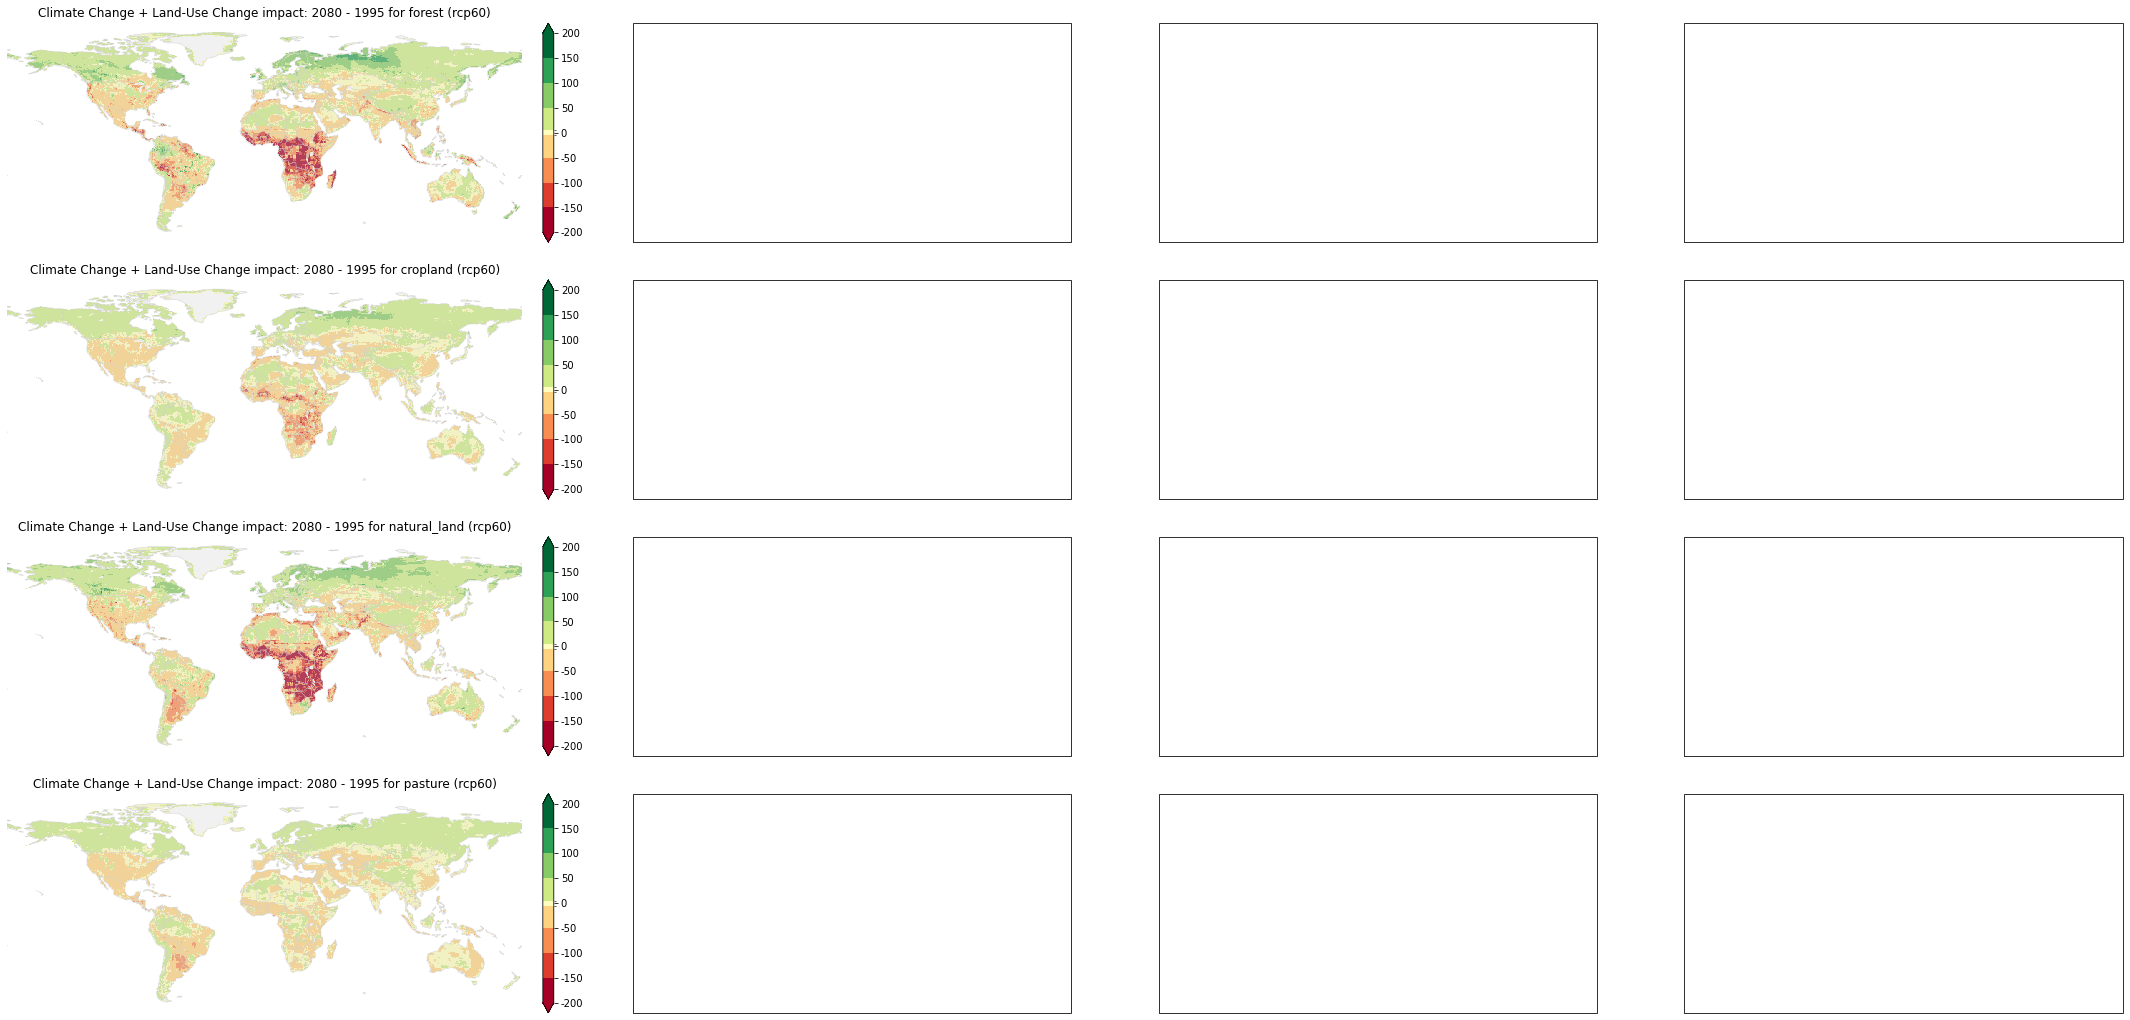

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
from matplotlib.colors import BoundaryNorm

warnings.filterwarnings('ignore', category=UserWarning)

models = ["GAM", "GBM"]
scenarios = ["rcp60"]

habitats = ["forest", "cropland", "natural_land", "pasture"]

fig, axes = plt.subplots(nrows=len(habitats), ncols=4, figsize=(30, 15 * len(habitats)), subplot_kw={'projection': ccrs.PlateCarree()}, layout="compressed")
cmap = plt.get_cmap('RdYlGn')
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# Create empty arrays for storing the results for each habitat separately
diff_sum_bin_combined_per_habitat = {}

for habitat in habitats:
    diff_sum_bin_combined_per_habitat[habitat] = np.zeros([360, 720])

    for scenario in scenarios:
        historical_time = 1146
        future_times = [65]

        for future_time in future_times:
            diff_sum_bin_models = []

            for model in models:
                sumbin_hist = f"/storage/scratch/users/ch21o450/data/SR/{model}_{historical_time}_{scenario}_summedprobs_sum_{habitat}.nc"
                sumbin_fut = f"/storage/scratch/users/ch21o450/data/SR/{model}_{future_time}_{scenario}_summedprobs_sum_{habitat}.nc"

                mean_sum_bin_hist = xr.open_dataset(sumbin_hist, decode_times=False).to_array().isel(variable=0)
                mean_sum_bin_future = xr.open_dataset(sumbin_fut, decode_times=False).to_array().isel(variable=0)

                # Calculate the differences
                diff_sum_bin = mean_sum_bin_future - mean_sum_bin_hist

                # Append the differences to the model-specific list
                diff_sum_bin_models.append(diff_sum_bin)

            # Calculate the ensemble mean outside of the innermost loop
            diff_sum_bin_ensemble = xr.concat(diff_sum_bin_models, dim="ensemble").mean(dim="ensemble")

            # Append the ensemble mean to the overall results for this habitat
            diff_sum_bin_combined_per_habitat[habitat] = diff_sum_bin_ensemble

# Create subplots for each habitat
for row, habitat in enumerate(habitats):
    ax = axes[row, 0]

    cmap = plt.get_cmap('RdYlGn')
    boundaries = [-200, -150, -100, -50, -5, 5, 50, 100, 150, 200]
    norm = BoundaryNorm(boundaries, cmap.N)

    # Plot the ensemble mean difference for each panel
    im = ax.pcolormesh(diff_sum_bin_combined_per_habitat[habitat]['lon'].values, diff_sum_bin_combined_per_habitat[habitat]['lat'].values,
                       np.where(diff_sum_bin_combined_per_habitat[habitat].values != 0, diff_sum_bin_combined_per_habitat[habitat].values, np.nan),
                       transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)

    countries.plot(ax=ax, color="lightgray", zorder=1, alpha=0.3)
    ax.set_title(f"Climate Change + Land-Use Change impact: {year_indices[future_time]} - 1995 for {habitat} (rcp60)", loc='center')

    ax.axis('off')
    ax.coastlines(color='lightgray', linewidth=0.5)
    ax.set_extent((-180, 180, -63, 90))
    ax.add_feature(cfeature.BORDERS, color='lightgray', linewidth=0.5)

    ticks_b = np.array([-200, -150, -100, -50, 0, 50, 100, 150, 200])
    tick_labels = [str(int(tick)) for tick in ticks_b]

    cbar = plt.colorbar(im, ax=ax, fraction=0.024, pad=0.04, spacing='proportional', ticks=ticks_b, extend='both')
    cbar.set_ticklabels(tick_labels)

    
plt.show()


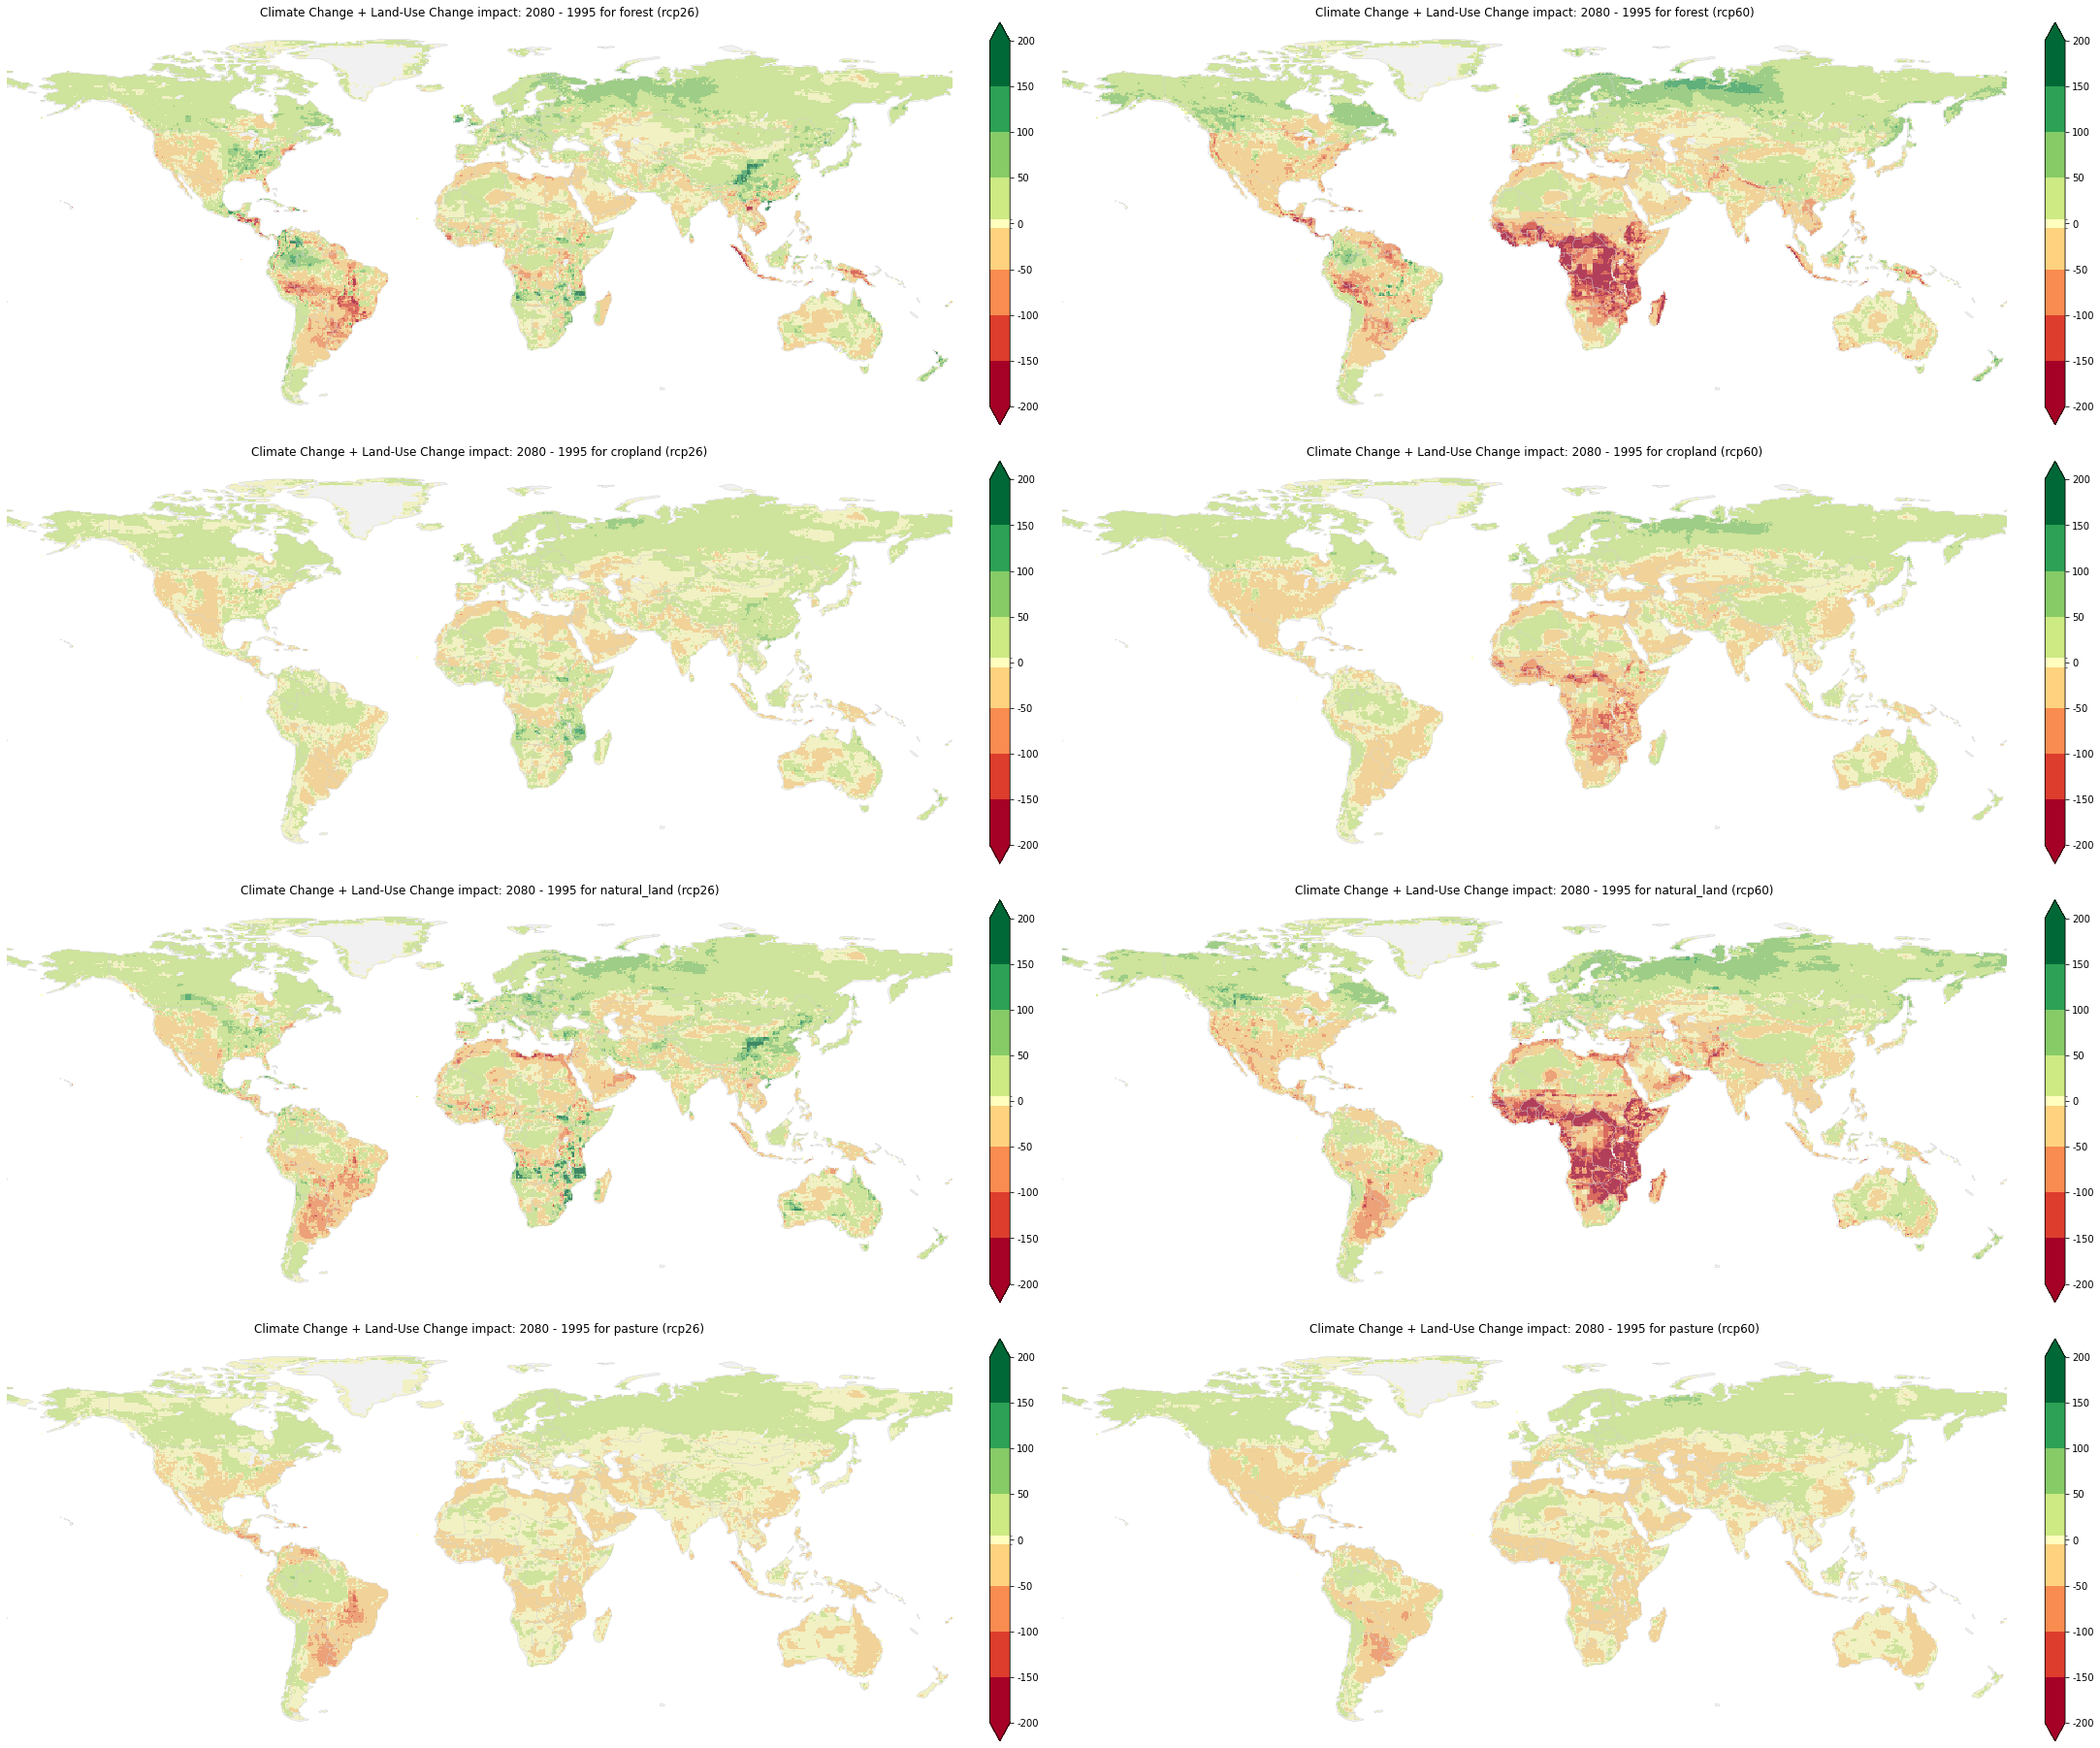

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
from matplotlib.colors import BoundaryNorm

warnings.filterwarnings('ignore', category=UserWarning)

models = ["GAM", "GBM"]
scenarios = [ "rcp26","rcp60",]

habitats = ["forest", "cropland", "natural_land", "pasture"]

fig, axes = plt.subplots(nrows=len(habitats), ncols=2, figsize=(30, 15 * len(habitats)), subplot_kw={'projection': ccrs.PlateCarree()}, layout="compressed")
cmap = plt.get_cmap('RdYlGn')
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# Create empty arrays for storing the results for each habitat separately
diff_sum_bin_combined_per_habitat = {}

for habitat in habitats:
    for scenario in scenarios:
        diff_sum_bin_combined_per_habitat[(habitat, scenario)] = np.zeros([360, 720])

        historical_time = 1146
        future_times = [65]

        for future_time in future_times:
            diff_sum_bin_models = []

            for model in models:
                sumbin_hist = f"/storage/scratch/users/ch21o450/data/SR/{model}_{historical_time}_{scenario}_summedprobs_sum_{habitat}.nc"
                sumbin_fut = f"/storage/scratch/users/ch21o450/data/SR/{model}_{future_time}_{scenario}_summedprobs_sum_{habitat}.nc"

                mean_sum_bin_hist = xr.open_dataset(sumbin_hist, decode_times=False).to_array().isel(variable=0)
                mean_sum_bin_future = xr.open_dataset(sumbin_fut, decode_times=False).to_array().isel(variable=0)

                # Calculate the differences
                diff_sum_bin = mean_sum_bin_future - mean_sum_bin_hist

                # Append the differences to the model-specific list
                diff_sum_bin_models.append(diff_sum_bin)

            # Calculate the ensemble mean outside of the innermost loop
            diff_sum_bin_ensemble = xr.concat(diff_sum_bin_models, dim="ensemble").mean(dim="ensemble")

            # Append the ensemble mean to the overall results for this habitat and scenario
            diff_sum_bin_combined_per_habitat[(habitat, scenario)] = diff_sum_bin_ensemble

# Create subplots for each habitat and scenario
for row, habitat in enumerate(habitats):
    for col, scenario in enumerate(scenarios):
        ax = axes[row, col]

        cmap = plt.get_cmap('RdYlGn')
        boundaries = [-200, -150, -100, -50, -5, 5, 50, 100, 150, 200]
        norm = BoundaryNorm(boundaries, cmap.N)

        # Plot the ensemble mean difference for each panel
        im = ax.pcolormesh(diff_sum_bin_combined_per_habitat[(habitat, scenario)]['lon'].values,
                           diff_sum_bin_combined_per_habitat[(habitat, scenario)]['lat'].values,
                           np.where(diff_sum_bin_combined_per_habitat[(habitat, scenario)].values != 0,
                                    diff_sum_bin_combined_per_habitat[(habitat, scenario)].values, np.nan),
                           transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)

        countries.plot(ax=ax, color="lightgray", zorder=1, alpha=0.3)
        ax.set_title(f"Climate Change + Land-Use Change impact: {year_indices[future_time]} - 1995 for {habitat} ({scenario})", loc='center')

        ax.axis('off')
        ax.coastlines(color='lightgray', linewidth=0.5)
        ax.set_extent((-180, 180, -63, 90))
        ax.add_feature(cfeature.BORDERS, color='lightgray', linewidth=0.5)

        ticks_b = np.array([-200, -150, -100, -50, 0, 50, 100, 150, 200])
        tick_labels = [str(int(tick)) for tick in ticks_b]

        cbar = plt.colorbar(im, ax=ax, fraction=0.024, pad=0.04, spacing='proportional', ticks=ticks_b, extend='both')
        cbar.set_ticklabels(tick_labels)
        

plt.savefig("/storage/homefs/ch21o450/scripts/BioScenComb/main_figures/Figure_3")
plt.show()


In [14]:
import pandas as pd
models = ["GAM"]
taxas = ["Amphibians", "Mammals", "Bird"]
habitats = ["pasture", "forest", "natural_land", "cropland"]
scenarios = ["rcp26", "rcp60"]
# Initialize an empty list to store data
data = []

# Assuming you have defined habitats, taxas, and models before
for habitat in habitats:
    for taxa in taxas:
        for model in models:
            # Read the CSV file
            file_path = f'/storage/homefs/ch21o450/scripts/BioScenComb/habitat_counts/habitat_{habitat}_{taxa}.csv'
            df = pd.read_csv(file_path)

            # Get the species list
            species_list = df['Species'].tolist()

            # Append data to the list
            data.append({
                'Habitat': habitat,
                'Taxa': taxa,
                'Model': model,
                'SpeciesListLength': len(species_list)
            })

# Create a DataFrame from the list of dictionaries
result_df = pd.DataFrame(data)

# Print or use the resulting DataFrame as needed
print(result_df)


         Habitat        Taxa Model  SpeciesListLength
0        pasture  Amphibians   GAM                642
1        pasture     Mammals   GAM                436
2        pasture        Bird   GAM               2096
3         forest  Amphibians   GAM               2235
4         forest     Mammals   GAM               2907
5         forest        Bird   GAM               5770
6   natural_land  Amphibians   GAM               2211
7   natural_land     Mammals   GAM               2210
8   natural_land        Bird   GAM               4644
9       cropland  Amphibians   GAM                615
10      cropland     Mammals   GAM                542
11      cropland        Bird   GAM               1987


In [15]:
import pandas as pd

# Initialize an empty list to store data
data = []

# Assuming you have defined habitats, taxas, and models before
for habitat in habitats:
    for taxa in taxas:
        # Initialize a dictionary to store species list lengths for the current habitat and taxa
        species_lengths = {}
        for model in models:
            # Read the CSV file
            file_path = f'/storage/homefs/ch21o450/scripts/BioScenComb/habitat_counts/habitat_{habitat}_{taxa}.csv'
            df = pd.read_csv(file_path)

            # Get the species list
            species_list = df['Species'].tolist()

            # Add species list length to the dictionary
            species_lengths[model] = len(species_list)

        # Append data to the list
        data.append({
            'Taxa': taxa,
            'Habitat': habitat,
            **species_lengths  # Unpack the species lengths dictionary
        })

# Create a DataFrame from the list of dictionaries
result_df = pd.DataFrame(data)

# Pivot the DataFrame to the desired format
result_df_pivoted = result_df.pivot(index='Taxa', columns='Habitat')

# Fill NaN values with an empty string if needed
result_df_pivoted = result_df_pivoted.fillna('')

# Print or use the resulting pivoted DataFrame as needed
print(result_df_pivoted)


                GAM                            
Habitat    cropland forest natural_land pasture
Taxa                                           
Amphibians      615   2235         2211     642
Bird           1987   5770         4644    2096
Mammals         542   2907         2210     436
